<h1><center>Fundamentals of Q learning 

## Before we start, let's learn about gym

    * Gym is an OpenAI platform which provides easy access to various environments. 
    * Environment (of a game) will have attributes such as `action_space`, `observation_space` & `reward_range`
    * We use `step()` method to advance environment when a particular action is chosen
    * `step()` returns four outputs; observation, reward, done, info
        > Observation is `Discrete`/ `Box` object which gives info about what state env is in currently 
        > Reward is what we achieved after action
        > Done will be true if the env reaches its end state
        > Info contains metadata
        
Read more here: https://gym.openai.com/docs 


____________________________

## Now a brief about RL 

Reinforced Learning is all about learning what chain of actions to follow to go through a certain chain of states in order to reach a final state in a way that maximizes our **total** reward

### Terminology
1. Environment
2. Agent
3. State
4. Observation
5. Action
6. Reward
7. Environment modelling by an Agent
8. Policy of an Agent
9. Value function of an Agent
    * Value function for a fixed action ($\pi$) for each state $(S)$ : $Q_{\pi}(S_i)$
    * Value function for variable actions for each state $(S)$ : $Q(a_i, S_i)$

# The whole drama is for learning $Q(a_i, S_i)$

The simplest form of representing this function is using a table. 
A table of dimension $(#states, #actions)$. Each cell in the table denotes the value of being in a state $s$ and taking an action $a$ in $s$

## Frozen lake env in Gym
To establish and learn that kind of Q-table, Frozen lake env in Gym would be best fit.
This env is 4x4 grid, each cell can be a stable block, a hole or a goal position. 
Reward to be in any cell except goal cell is zero. Goal cell carries a reward of one.

Now possible states in this env is one of the cells, so, 16.
Similarly possible actions (left, right, top, bottom) are 4.
Let's dive.


In [1]:
import gym
import numpy as np

env = gym.make('FrozenLake-v0')

[2017-07-21 01:58:51,712] Making new env: FrozenLake-v0


In [2]:
print "#states =", env.observation_space.n
print "#actions =", env.action_space.n

#states = 16
#actions = 4


In [21]:
# Init Q table (Value function)

Q = np.zeros([env.observation_space.n, env.action_space.n])

# Now train the env by processing rewards and learn the Q function
episodes = 2000
learning_rate = 0.80
discount_fact = 0.95
rewards_over_episodes = []

# Play #episode games
for i in range(1, episodes):
    accumulated_reward_for_episode = 0
    done = False
    s = env.reset()  # Reset and get default/ init state.
    
    for _ in range(99):
        
        # We are learning now, greedily pick an action while being in state `s`
        action = np.argmax(Q[s, :] + (np.random.randn(1, env.action_space.n)*(1./(1 + i))))

        # See the consequence of this action
        new_state, reward, done, _ = env.step(action)
        
        # Alright, we have received reward, let's remember what earned us that amount
        # Bellman equation & the fact that we want the updation to be steady and small
        Q[s, action] =   Q[s, action] + learning_rate * (reward + (discount_fact * np.max(Q[new_state, :])))
                       - learning_rate * Q[s, action]
        
        # Updating iteration vals
        accumulated_reward_for_episode += reward
        s = new_state
        
        # Episode ended
        if done is True:
            break
            
    rewards_over_episodes.append(accumulated_reward_for_episode)
    if i % 100 == 0:
        print "Reward @ episode %d = %.2f" % (i, sum(rewards_over_episodes)/episodes)
    
print "TRAINING ENDED"
    

Reward @ episode 100 = 0.00
Reward @ episode 200 = 0.02
Reward @ episode 300 = 0.04
Reward @ episode 400 = 0.06
Reward @ episode 500 = 0.09
Reward @ episode 600 = 0.11
Reward @ episode 700 = 0.14
Reward @ episode 800 = 0.17
Reward @ episode 900 = 0.21
Reward @ episode 1000 = 0.24
Reward @ episode 1100 = 0.28
Reward @ episode 1200 = 0.31
Reward @ episode 1300 = 0.34
Reward @ episode 1400 = 0.37
Reward @ episode 1500 = 0.41
Reward @ episode 1600 = 0.45
Reward @ episode 1700 = 0.49
Reward @ episode 1800 = 0.52
Reward @ episode 1900 = 0.56
TRAINING ENDED


In [16]:
print Q

[[  2.43567931e-01   1.29953830e-02   1.37789988e-02   1.32270488e-02]
 [  7.30154553e-04   8.34075080e-04   3.19486029e-04   2.26955196e-01]
 [  2.92785670e-03   9.91106073e-02   4.55518449e-03   4.24503566e-03]
 [  6.06637322e-04   5.89402814e-04   0.00000000e+00   4.19002118e-02]
 [  3.60335085e-01   3.60273873e-03   8.06561456e-03   3.68616199e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.28962214e-04   1.14934259e-04   5.71909935e-02   4.39082815e-06]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   5.65256390e-03   4.06607033e-01]
 [  3.66698844e-03   2.41311287e-01   0.00000000e+00   0.00000000e+00]
 [  7.74143483e-01   2.15206745e-04   0.00000000e+00   1.26652371e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   7.30694621e-01   0.00000000e+00]
 [  0.

### All good, but what if the env is complex?
In a way, that it has waay too many states and waaay too many possible actions?

Nothing, there will be a bigger table.
But, we have a better method to represent that kind of a big table 

We will train a Neuralnet to learn this Value function by feeding reward converted as target Q values.
Let's do that.

What should be the NeuralNet(NN) architecture? 

In the above code, we were trying to retrieve value benifits of all possible actions given a state $(s)$. 
So, this NN should accept state as input and output values (probabilities) of taking each of the four actions.
That means, NN will have an input layer of $(1x16)$ and output layer of $(1x4)$. 

Let there just be one layer in between, my hardware is too slow. 

In [7]:
# Let's first define NN
import tensorflow as tf
import numpy as np
import gym
env = gym.make('FrozenLake-v0')

# Input layer
inputs = tf.placeholder(shape=(1, 16), dtype=tf.float32)

# Sandwich layer (1, 16)
layer_W = tf.Variable(tf.random_uniform((16, 32), 0, 0.1, dtype=tf.float32))
layer_b = tf.Variable(tf.zeros((1, 32), dtype=tf.float32))
layer = tf.matmul(inputs, layer_W)

# Output layer
output_W = tf.Variable(tf.random_uniform((16,4), 0, 0.1), dtype=tf.float32)
output_b = tf.Variable(tf.zeros((1, 4), dtype=tf.float32))
output = tf.matmul(inputs, output_W)
Q = output
get_action = tf.argmax(Q, 1)

# Error function
Q_target = tf.placeholder(shape=(1, 4), dtype=tf.float32)
error = Q_target - Q
reduced_mean_square_error = tf.reduce_sum(tf.square(error))  # loss function

# Minimize loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
back_propagate = optimizer.minimize(reduced_mean_square_error)


###################################################################

sess = tf.Session()
init_global_vars = tf.global_variables_initializer()

episodes = 2000
discount_fact = 0.95
rewards_over_episodes = []
sess.run(init_global_vars)

# Play #episode games
for i in range(1, episodes):
    accumulated_reward_for_episode = 0
    done = False
    s = env.reset()  # Reset and get default/ init state.
    
    for _ in range(99):
        
        # We are learning now, greedily pick an action while being in state `s`
        # The following lines are that stupidity that kills your PC
#        s_one_hot = tf.one_hot(indices=[s], depth=16)
#        s_one_hot = sess.run(s_one_hot)
        s_one_hot = np.zeros((1, 16))
        s_one_hot[0, s] = 1
        action, Q_s = sess.run([get_action, Q], {inputs: s_one_hot})
        if np.random.rand(1) < 0.15:
                action[0] = env.action_space.sample()

        # See the consequence of this action
        new_state, reward, done, _ = env.step(action[0])
        # These too! 
#        env.render()
#        new_state_one_hot = tf.one_hot(indices=[new_state], depth=16)
#        new_state_one_hot = sess.run(new_state_one_hot)
        new_state_one_hot = np.zeros((1, 16))
        new_state_one_hot[0, new_state] = 1
        # Alright, we have received reward, let's remember what earned us that amount
        # Bellman equation & the fact that we want the updation to be steady and small
        Q_new = sess.run(Q, {inputs: new_state_one_hot})
        Q_targeted = Q_s
        Q_targeted[0, action[0]] = reward + (discount_fact * np.max(Q_new))
        sess.run(back_propagate, {Q_target: Q_targeted, inputs: s_one_hot })
#        print sess.run(error, {Q_target: Q_targeted, inputs: s_one_hot })
        
        # Updating iteration vals
        accumulated_reward_for_episode += reward
        s = new_state
        
        # Episode ended
        if done is True:
            break
            
    rewards_over_episodes.append(accumulated_reward_for_episode)
    if i % 1 == 0 and False:
        print "Reward @ episode %d = %.2f" % (i, sum(rewards_over_episodes)/episodes)
print "Percentage completion = %.2f" % ((sum(rewards_over_episodes) * 100.0)/ episodes)
print "TRAINING ENDED"



[2017-07-21 15:52:04,272] Making new env: FrozenLake-v0


 Percentage completion = 17.80
TRAINING ENDED


In [9]:
# Analyse what this Agent has learned
env.render()
sess.run(Q, {inputs: [[0, 1, 0, 0,  0, 0, 0, 0,  0, 0, 0, 0,  0, 0, 0, 0]]})

  (Left)
SFFF
FHFH
FFFH
HFFG


array([[ 0.09951197,  0.12108366,  0.10376973,  0.15691705]], dtype=float32)

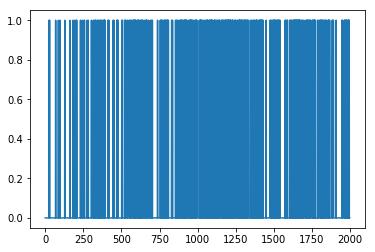

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(rewards_over_episodes)

## TODO

1. Try other architectures and see how runs-to-learn is changing 
2. Reduce exploration as we learn better 
3. Modify env.render() to print inline (Easy to visualize)